In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import welch, lfilter
from scipy import fftpack

In [2]:
def plot_time_domain_channels_stereo(time, lc, rc):
    #Plota as figuras ao longo do tempo
    #Plota os canais esquerdo e direito
    plt.figure(1,figsize=(20, 5))
    plt.plot(time, lc, label="Canal esquerdo")
    plt.legend()
    plt.xlabel("Tempo [s]")
    plt.ylabel("Amplitude")
    plt.show()

    plt.figure(2,figsize=(20, 5))
    plt.plot(time, rc, color="red",label="Canal direito")
    plt.legend()
    plt.xlabel("Tempo [s]")
    plt.ylabel("Amplitude")
    plt.show()

In [3]:
def plot_spect_welch_channels_stereo(lc, rc, fs):
    #Sample Frequencies, Power Spectral Density
    sf_lc, psd_lc = welch(
        x=lc, 
        fs=fs, 
        window='flattop', 
        nperseg=512, 
        scaling='spectrum'
    )
    sf_rc, psd_rc = welch(
        x=rc, 
        fs=fs, 
        window='flattop', 
        nperseg=512, 
        scaling='spectrum'
    )

    #Plota o espectro do sinal para frequencias normalizadas entre 0 1 pi 
    #(frequencias positivas)
    plt.subplots(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.semilogy(sf_lc, psd_lc, label="Canal esquerdo")
    plt.legend()
    plt.xlabel('Frequencia [rad]')
    plt.ylabel('Espectro')

    plt.subplot(1, 2, 2)
    plt.semilogy(sf_rc, psd_rc, color="red", label="Canal direito")
    plt.legend()
    plt.xlabel('Frequencia [rad]')
    plt.ylabel('Espectro')
    plt.show()

In [4]:
def plot_spect_fft_channels_stereo(lc,rc, sampling_rate, nfft):
    freq_lc = np.linspace(0., sampling_rate, nfft) #Interpola para determinar eixo da frequencia
    sig_fft_lc = fftpack.rfft(lc,nfft)
    plt.subplots(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.title("Canal esquerdo")
    plt.plot(freq_lc, np.abs(sig_fft_lc), label="fft")
    plt.legend()
    plt.xlabel('Frequencia [Hz]')
    plt.ylabel('Espectro de amplitudes')
    #plt.plot(freq_lc, np.abs(fftpack.fftshift(sig_fft_lc)), label="fftshift")
    plt.legend()

    freq_rc = np.linspace(0., sampling_rate, nfft) #Interpola para determinar eixo da frequencia
    sig_fft_rc = fftpack.rfft(rc,nfft)
    plt.subplot(1, 2, 2)
    plt.title("Canal direito")
    plt.plot(freq_rc, np.abs(sig_fft_rc), color="red", label="fft")
    plt.legend()
    plt.xlabel('Frequencia [Hz]')
    plt.ylabel('Espectro de amplitudes')
    #plt.plot(freq_rc, np.abs(fftpack.fftshift(sig_fft_rc)), color="green", label="fftshift")
    plt.legend()
    plt.show()

In [5]:
#Carrega o arquivo
sampling_rate, data = wavfile.read('569127__josefpres__dark-loops-201-simple-mix-2-short-loop-60-bpm.wav')
#sampling_rate, data = wavfile.read('581010__xcreenplay__smoking-in-the-angel-section2.wav')

number_of_samples = data.shape[0]
number_of_channels = data.shape[1]

#Tempo total = numero de amostras / fs
duration = number_of_samples / sampling_rate

#Carrega o arquivo em dois canais (audio estereo)
left_channel = data[:, 0]
right_channel  = data[:, 1]

print(f"Numero de canais = {number_of_channels}")
print(f"Duracao = {duration}s")
print(f'Numero de amostras: {number_of_samples}')
print(f"Amostras por segundo: {sampling_rate}Hz")


Numero de canais = 2
Duracao = 64.0s
Numero de amostras: 2822400
Amostras por segundo: 44100Hz


/tmp/ipykernel_15210/1384073729.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, data = wavfile.read('569127__josefpres__dark-loops-201-simple-mix-2-short-loop-60-bpm.wav')


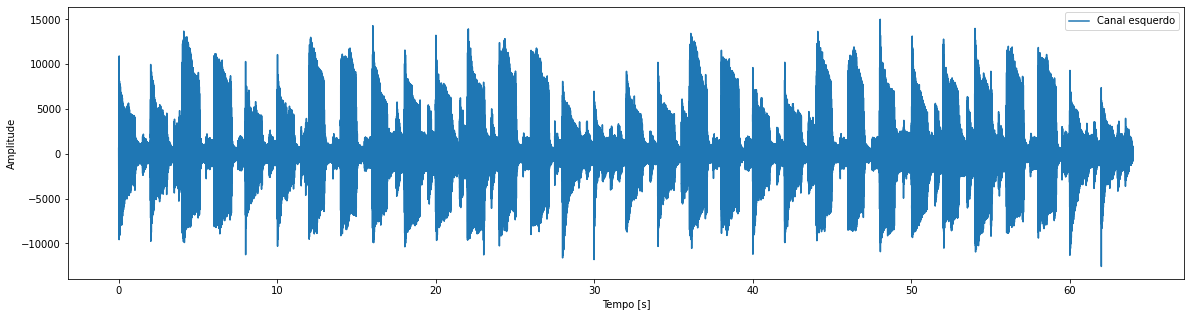

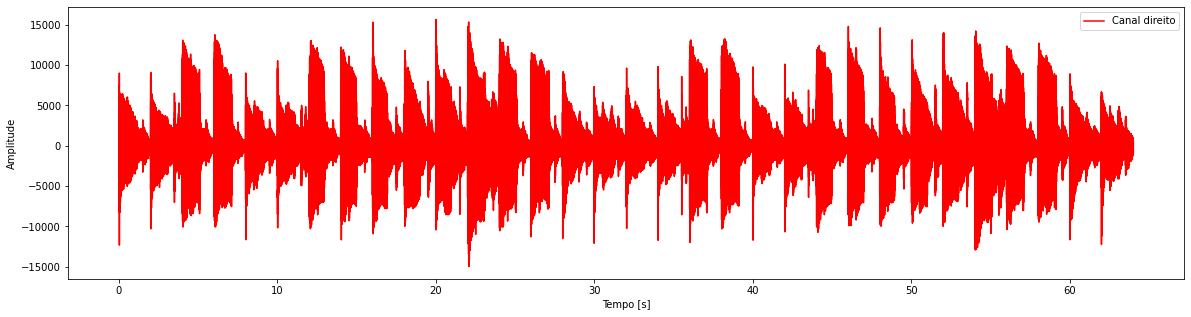

In [6]:
#Interpola para determinar eixo do tempo
time = np.linspace(0., duration, number_of_samples)
plot_time_domain_channels_stereo(
    time=time,
    lc=left_channel,
    rc=right_channel
)

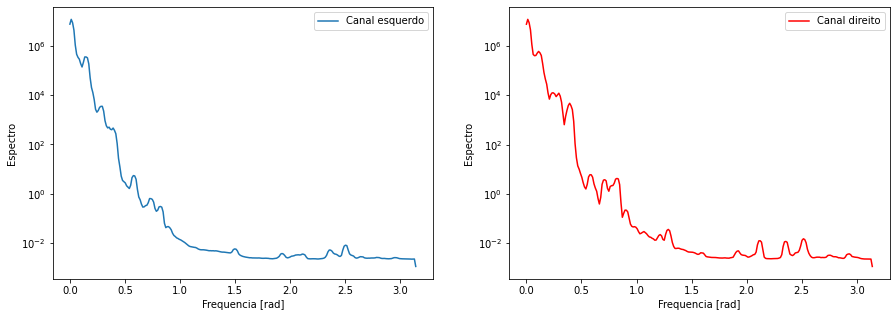

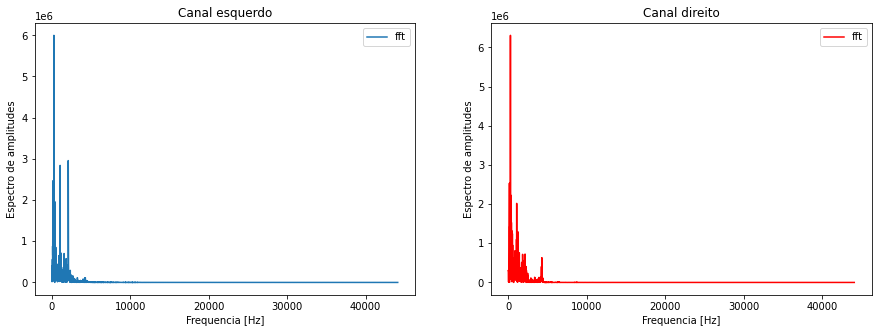

In [7]:
plot_spect_welch_channels_stereo(
    lc  = left_channel,
    rc  = right_channel,
    fs = 2*np.pi
)

plot_spect_fft_channels_stereo(
    lc  = left_channel,
    rc  = right_channel,
    sampling_rate=sampling_rate,
    nfft=4096
)

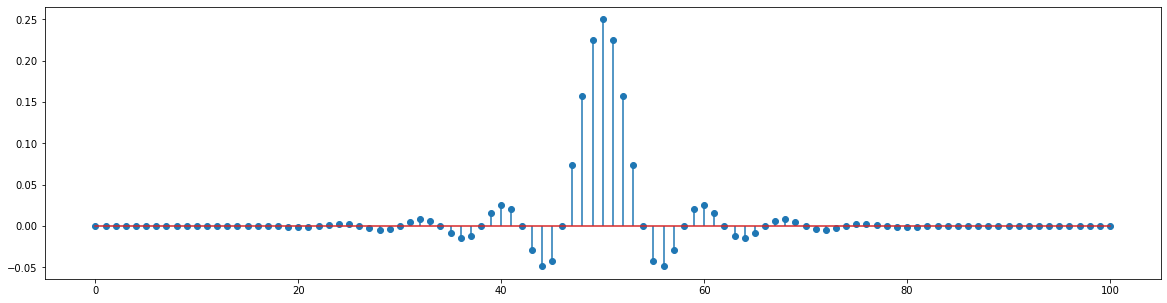

In [8]:
#Carrega os coeficientes do filtro
b = np.genfromtxt('coeffs.csv', delimiter=',')
#Plota coeficientes do filtro FIR
plt.figure(7, figsize=(20, 5))
plt.stem(b)
plt.show()

In [9]:
#Filtra os dados dos canais esquerdo e direito
filtered_lc = lfilter(b, 1, left_channel)
filtered_rc = lfilter(b, 1, right_channel)

In [10]:
#Dizimando o sinal pelo fator M
M=4

decimated_lc = filtered_lc[0:-1:M]
decimated_rc = filtered_rc[0:-1:M]

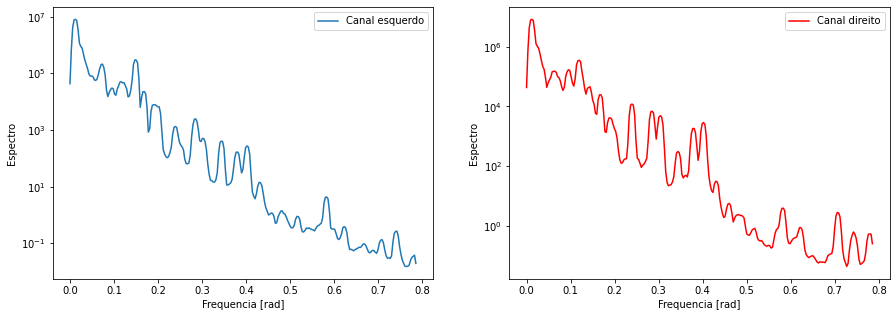

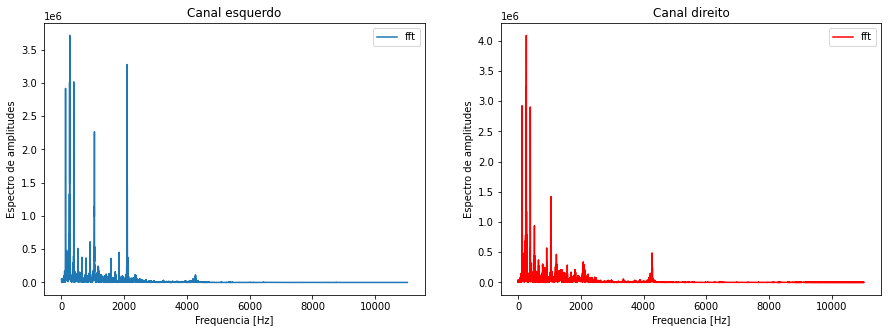

In [11]:
plot_spect_welch_channels_stereo(
    lc  = decimated_lc,
    rc  = decimated_rc,
    fs = (2*np.pi)/M
)

plot_spect_fft_channels_stereo(
    lc  = decimated_lc,
    rc  = decimated_rc,
    sampling_rate=sampling_rate//M,
    nfft=4096
)

In [12]:
# Escrita de arquivo dizimado
audio = np.array([decimated_lc, decimated_rc]).T
scaled = np.int16(audio/np.max(np.abs(audio)) * 32767)
filename = 'signal_decimated_' + str(M) + '.wav'
wavfile.write(filename, sampling_rate//M, scaled)

In [13]:
# Fator de interpolação
L = 4
interpolated_lc = np.zeros(L * len(filtered_lc))
interpolated_lc[::L] = filtered_lc

interpolated_rc = np.zeros(L * len(filtered_rc))
interpolated_rc[::L] = filtered_rc

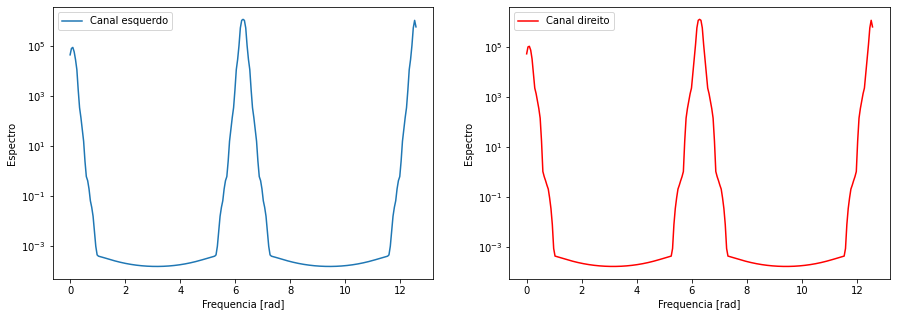

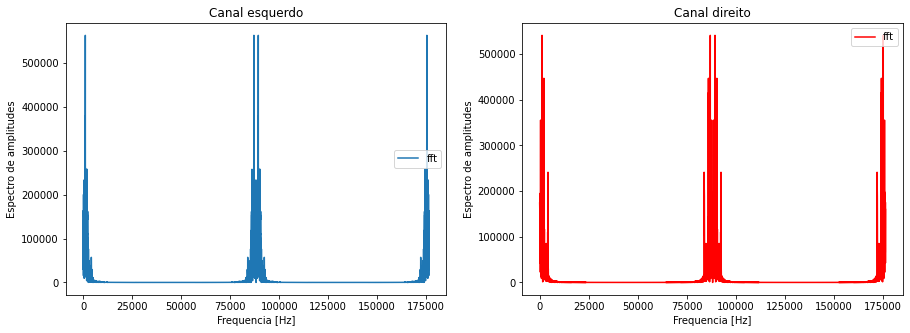

In [14]:
plot_spect_welch_channels_stereo(
    lc  = interpolated_lc,
    rc  = interpolated_rc,
    fs = (2*np.pi)*L
)

plot_spect_fft_channels_stereo(
    lc  = interpolated_lc,
    rc  = interpolated_rc,
    sampling_rate=sampling_rate*L,
    nfft=4096
)

In [15]:
# Escrita de arquivo interpolado
audio = np.array([interpolated_lc, interpolated_rc]).T
scaled = np.int16(audio/np.max(np.abs(audio)) * 32767)
filename = 'signal_interpolated_' + str(L) + '.wav'
wavfile.write(filename, sampling_rate*L, scaled)